In [94]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
%config InlineBackend.figure_format = 'retina'
# np.random.seed(0)

In [95]:
def swap_rows(df, row1, row2):
    df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
    return df

There are now 7 possible stimulus levels. Ordered by positivity they are

-3, -2, -1, 0, 1, 2, 3

Therefore we choose -3 as the baseline stimulus and analyse the responses in pairs

In [96]:
df = pd.read_csv('poll_responses2.csv')

In [97]:
df.groupby('Participant Name')['Response'].mean()

Participant Name
Andreas    0.271429
Lukas      0.142857
Tobias     0.117857
Name: Response, dtype: float64

In [98]:
# get response proport for each image
group = df.groupby(['Image', 'Participant Name'])['Response'].mean()
group

Image         Participant Name
image_-1.png  Andreas            -0.825
              Lukas              -0.950
              Tobias             -1.300
image_-2.png  Andreas            -1.700
              Lukas              -1.675
              Tobias             -1.550
image_-3.png  Andreas            -1.925
              Lukas              -2.275
              Tobias             -1.400
image_0.png   Andreas             0.300
              Lukas               0.075
              Tobias             -0.125
image_1.png   Andreas             1.425
              Lukas               1.375
              Tobias              1.225
image_2.png   Andreas             2.075
              Lukas               2.125
              Tobias              1.800
image_3.png   Andreas             2.550
              Lukas               2.325
              Tobias              2.175
Name: Response, dtype: float64

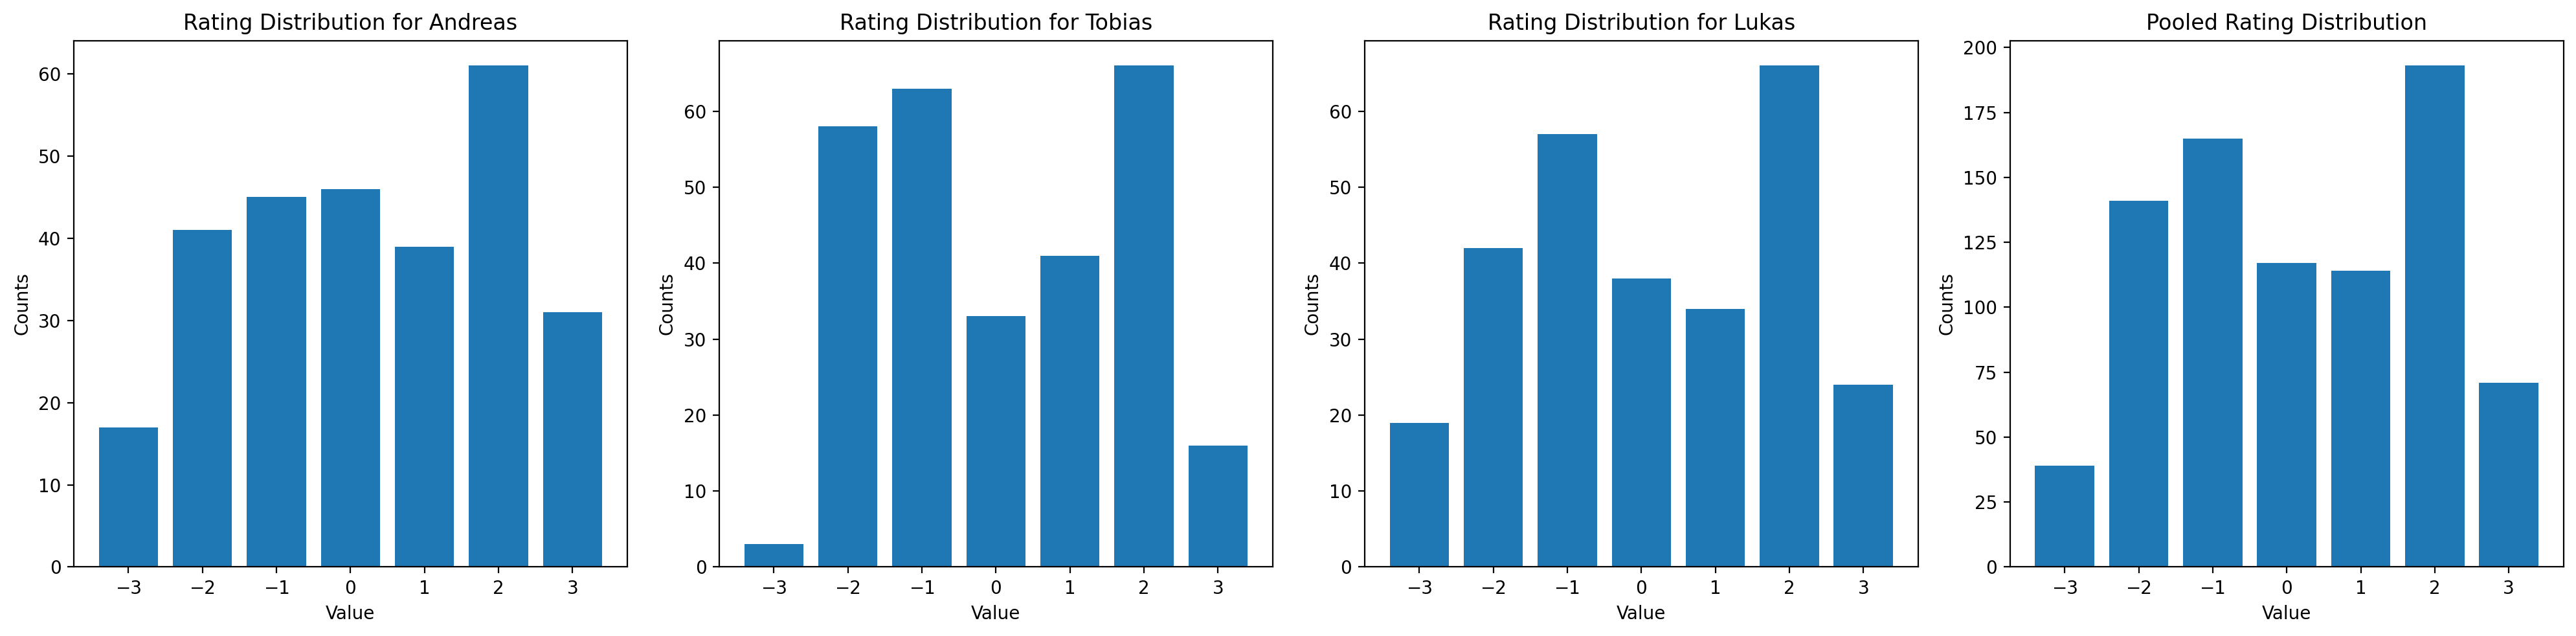

In [108]:
participants = df['Participant Name'].unique() 

fig, ax = plt.subplots(1, len(participants) + 1, figsize=(20, 5))
loc = [-3,-2,-1,0,1,2,3]
for i, person in enumerate(participants):
    data = df[df['Participant Name'] == person]['Response'].values

    # Calculate center of bins
    bins = np.histogram(data,bins=7)

    # Plot
    ax[i].bar(loc,bins[0])
    ax[i].set_title(f'Rating Distribution for {person}')
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Counts')
bins = np.histogram(df['Response'],bins=7)

# Plot
ax[-1].bar(loc,bins[0])
ax[-1].set_title('Pooled Rating Distribution')
ax[-1].set_xlabel('Value')
ax[-1].set_ylabel('Counts')
plt.tight_layout()

In [115]:
df

,Participant Name,Image,Response
0,Andreas,image_0.png,0
1,Andreas,image_-1.png,-2
2,Andreas,image_1.png,2
3,Andreas,image_3.png,3
4,Andreas,image_-3.png,-3
...,...,...,...
835,Lukas,image_0.png,0
836,Lukas,image_-3.png,-2
837,Lukas,image_-1.png,-1
838,Lukas,image_2.png,2


In [121]:
 df['Response'] >= -2

0       True
1       True
2       True
3       True
4      False
       ...  
835     True
836     True
837     True
838     True
839     True
Name: Response, Length: 840, dtype: bool

In [127]:
imgs = ['image_-2.png', 'image_-1.png', 'image_0.png', 'image_1.png', 'image_2.png', 'image_3.png']
stims = range(-2,4)

[-2, -1, 0, 1, 2, 3]

In [133]:
total_obs = 40*3
TPs = [len(df[(df['Image'] == img) & (df['Response'] >= stim)])/total_obs for img, stim in zip(imgs, stims)]
TPs

[0.9083333333333333,
 0.85,
 0.875,
 0.9666666666666667,
 0.8583333333333333,
 0.4083333333333333]

In [147]:
true_neg = len(df[df['Image'] == 'image_-3.png'])
FPs = [len(df[(df['Image'] == img) & (df['Response'] >= stim)])/len((df['Response'] <= stim)) for img, stim in zip(imgs, stims)]
FPs

[0.12976190476190477,
 0.12142857142857143,
 0.125,
 0.1380952380952381,
 0.12261904761904761,
 0.058333333333333334]

-3 as no_stim vs -2 as stim

In [148]:
P_TP1t = stats.norm.ppf(TPs)
P_FP1t = stats.norm.ppf(FPs)
line = stats.linregress(P_FP1t, P_TP1t)
a = line.slope
b = line.intercept
a, b # sigma, mu

(3.701544051597142, 5.514353472002987)

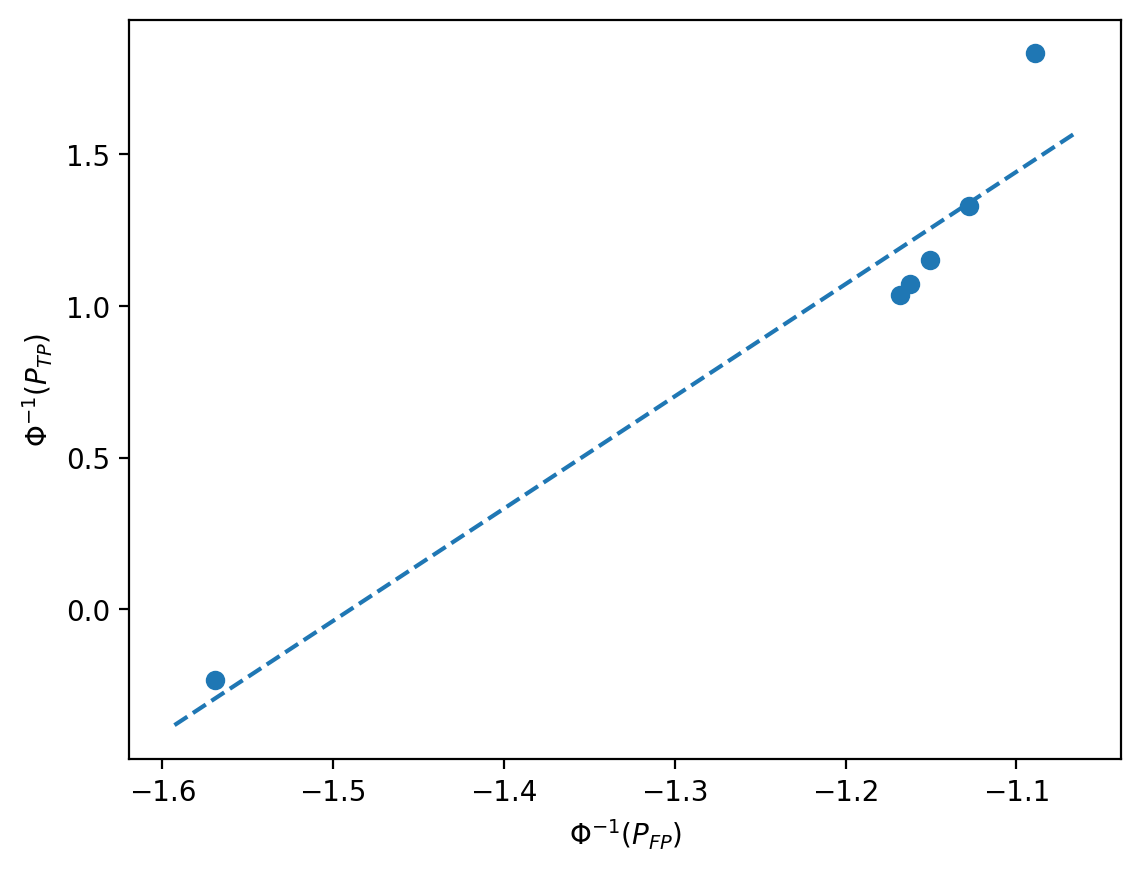

In [150]:
def abline(slope, intercept):
    """Plot a line from slope and intercept
    http://stackoverflow.com/questions/7941226/ddg#43811762
    """
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    return np.linspace(x_vals[0], x_vals[1], 100), np.linspace(y_vals[0], y_vals[1], 100)

plt.scatter(P_FP1t, P_TP1t)
plt.xlabel('$\Phi^{-1}(P_{FP})$')
plt.ylabel('$\Phi^{-1}(P_{TP})$')
# plt.xlim(0, 1); plt.ylim(0, 1)
# sigma is the slope and c is the intercept
rocx, rocy = abline(a, b)

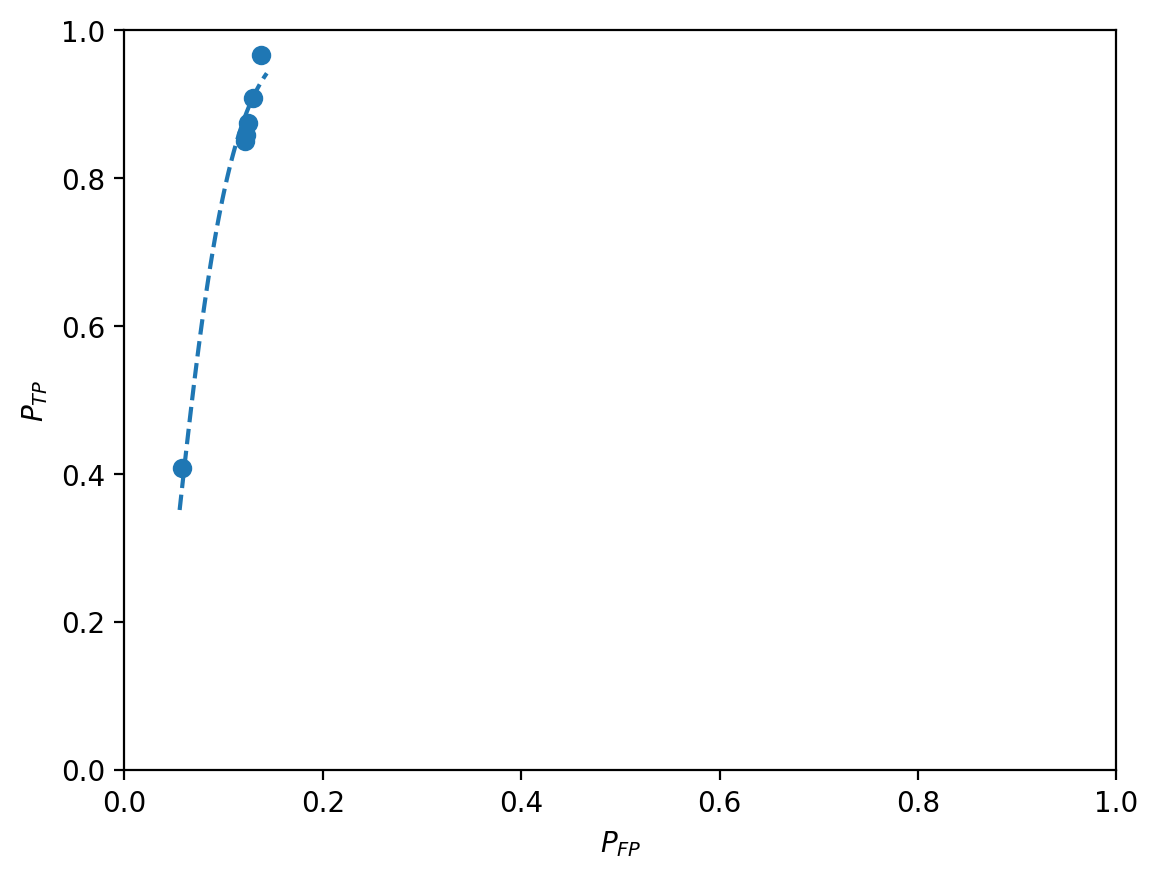

In [153]:
P_FP1_x = stats.norm.cdf(P_FP1t)
P_TP1_x = stats.norm.cdf(P_TP1t)
ROCx = stats.norm.cdf(rocx)
ROCy = stats.norm.cdf(rocy)
plt.scatter(P_FP1_x, P_TP1_x)
plt.plot(ROCx, ROCy, '--')
plt.xlabel('$P_{FP}$')
plt.ylabel('$P_{TP}$')
plt.xlim(0, 1); plt.ylim(0, 1);

In [151]:
def AUC(mu, sigma):
    '''Area Under the Curve (AUC) of the ROC curve when it is not probit transformed.'''
    return stats.norm.cdf(mu / np.sqrt(1 + sigma**2))
A = AUC(a, b)
A

0.7455282748377108